# Setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install pandas numpy jax sklearn selfies rdkit exmol kdeepensemble tqdm pyyaml h5py
!pip install -q tensorflowjs
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.4 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=2efd6304ac03a21af0806b5f43976588d7a75e9fd5af0ecc07f5871e7f8c7f2f
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5909 sha256=f32c3d85bcb4a92dacf4c38e81318fce4cc48a26dd74358a2eba60358a96bb8a
  Stored in directory: /root/.cache/pip/wheels/8e/34/5e/1dd3d652594bdf5df01109a683a455121d0b726978051bf720
Successfully built sklearn ratelimit
     ━━━━━━━━━━━━━━━

In [ ]:
# regular libraries
import pandas as pd
import numpy as np
import os

# ML
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflowjs as tfjs
import kdens

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Descriptors import MolWt

# Utils
import selfies as sf
import exmol
import urllib
from dataclasses import dataclass
import json
np.random.seed(0)

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9',
            'grid.color' : '#AAAAAA',
            'axes.edgecolor':'#333333',
            'figure.facecolor':'#FFFFFF',
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True
           })

# Getting data

In [ ]:
# path = "/content/drive/MyDrive/WhiteLab/sol-nn/ml"
!unzip -o data.zip
path = "."

with open(f"{path}/voc.json", 'r') as inp:
  voc = json.load(inp)

Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/ESOL.csv           
  inflating: __MACOSX/data/._ESOL.csv  
  inflating: data/padelAqSolDB.csv   
  inflating: __MACOSX/data/._padelAqSolDB.csv  
   creating: data/.ipynb_checkpoints/
  inflating: __MACOSX/data/._.ipynb_checkpoints  
  inflating: data/SolChal2-2.csv     
  inflating: __MACOSX/data/._SolChal2-2.csv  
  inflating: data/SolChal2-1.csv     
  inflating: __MACOSX/data/._SolChal2-1.csv  
  inflating: data/SolChal1.csv       
  inflating: __MACOSX/data/._SolChal1.csv  
  inflating: data/curated-solubility-dataset.csv  
  inflating: __MACOSX/data/._curated-solubility-dataset.csv  


## Getting AqSolDB

In [ ]:
# Is this link reliable?
# !wget -cO - https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/OVHAW8/RLVXZU > AqSolDB.tsv
# AqSolDB = pd.read_csv("AqSolDB.tsv", sep="\t")

AqSolDB = pd.read_csv(f"{path}/data/curated-solubility-dataset.csv")

descriptors = AqSolDB.iloc[:, 9:]
labels = AqSolDB["Solubility"]

print(f"The model has {len(AqSolDB)} unique entries.")

The model has 9982 unique entries.


## Getting Solubility Challenge data

In [ ]:
SolChal1   = pd.read_csv(f"{path}/data/SolChal1.csv")
# SolChal1  = pd.read_csv(f"{path}/data/SolChal1.csv")
SolChal2_1 = pd.read_csv(f"{path}/data/SolChal2-1.csv")
SolChal2_2 = pd.read_csv(f"{path}/data/SolChal2-2.csv")

# SolChal1 = SolChal1.dropna(how="all", axis=0)

In [ ]:
def calcS0(entry):
  try:
    return np.log10(1e-3*entry["expSolubility"]/MolWt(MolFromSmiles(entry["SMILES"])))
  except:
    return None

SolChal1["Solubility"] = SolChal1.apply(calcS0, axis=1)

In [ ]:
#Checking for challenge molecules on training dataset
match = []
for s in pd.concat([SolChal1, SolChal2_1, SolChal2_2], axis=0)["SMILES"]:
  for a in AqSolDB["SMILES"]:
    if (a==s):
      match.append(s)

print(f"There are {'' if match else 'no'} matches between AqSolDB and the Challenges")

There are no matches between AqSolDB and the Challenges


## Getting ESOL data

In [ ]:
ESOL = pd.read_csv(f"{path}/data/ESOL.csv")
ESOL = ESOL.rename({"measured log(solubility:mol/L)": "Solubility"}, axis=1)

# Analysing

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

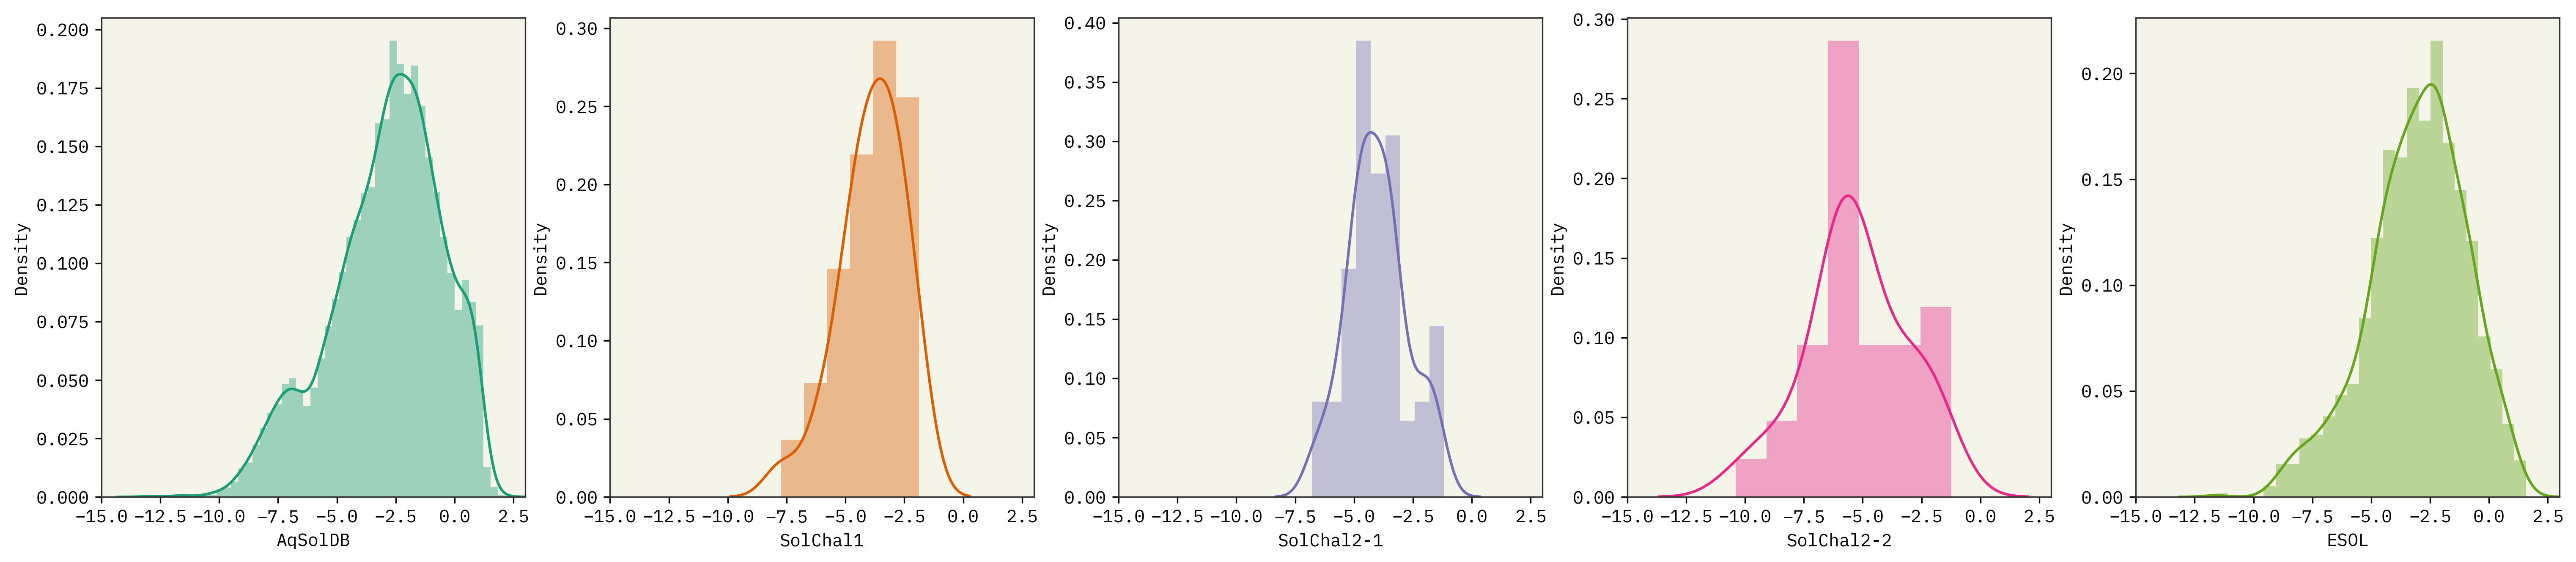

In [ ]:
y = AqSolDB["Solubility"]

ys = pd.DataFrame({
    "AqSolDB": AqSolDB["Solubility"],
    "SolChal1": SolChal1["Solubility"],
    "SolChal2-1": SolChal2_1["Solubility"],
    "SolChal2-2": SolChal2_2["Solubility"],
    "ESOL" : ESOL["Solubility"]
})

fig, axs = plt.subplots(ncols=5, figsize=(25,5), dpi=300)
for i, (name, y) in enumerate(ys.items()):
  # sns.histplot(y, ax=axs[i], color=f"C{i}")
  # sns.histplot(y, ax=axs[i], color=f"black", element="poly", fill=False)
  sns.distplot(y, ax=axs[i], color=f"C{i}")
  axs[i].set_xlim(-15,3)


# Cleaning up

In [ ]:
df = AqSolDB[:]

# DNN

In [ ]:
@dataclass
class Config:
    vocab_size: int = len(voc)
    example_number: int = len(df)
    batch_size: int = 16
    buffer_size: int = 10000
    rnn_units: int = 64
    hidden_dim: int = 32
    embedding_dim: int = 64
    reg_strength: float = 0.01
    lr: float = 1e-4
    drop_rate: float = 0.35
    epochs: int = 150
    nmodels: int = 1
    adv_epsilon: float = 1e-3

config = Config()
aug_data = 10
model_name = "sarc_lstm_r_f"

### Treating data

In [ ]:
df_AqSolDB = AqSolDB.copy()
df_SolChal1 = SolChal1.copy()
df_SolChal2_1 = SolChal2_1.copy()
df_SolChal2_2 = SolChal2_2.copy()

In [ ]:
import random
from rdkit import Chem

def randomize_smiles(mol, random_type=None, isomericSmiles=True):
    """
    From: https://github.com/rxn4chemistry/rxn_yields
    From: https://github.com/undeadpixel/reinvent-randomized and https://github.com/GLambard/SMILES-X
    Returns a random SMILES given a SMILES of a molecule.
    :param mol: A Mol object
    :param random_type: The type (unrestricted, restricted, rotated) of randomization performed.
    :return : A random SMILES string of the same molecule or None if the molecule is invalid.
    """
    if random_type is None:
      random_type = np.random.choice(['unrestricted', 'restricted', 'rotated'])

    if random_type == "unrestricted":
        return Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=isomericSmiles)
    elif random_type == "restricted":
        new_atom_order = list(range(mol.GetNumAtoms()))
        random.shuffle(new_atom_order)
        random_mol = Chem.RenumberAtoms(mol, newOrder=new_atom_order)
        return Chem.MolToSmiles(random_mol, canonical=False, isomericSmiles=isomericSmiles)
    elif random_type == 'rotated':
        n_atoms = mol.GetNumAtoms()
        rotation_index = random.randint(0, n_atoms-1)
        atoms = list(range(n_atoms))
        new_atoms_order = (atoms[rotation_index%len(atoms):]+atoms[:rotation_index%len(atoms)])
        rotated_mol = Chem.RenumberAtoms(mol,new_atoms_order)
        return Chem.MolToSmiles(rotated_mol, canonical=False, isomericSmiles=isomericSmiles)
    raise ValueError("Type '{}' is not valid".format(random_type))

smiles = list(df_AqSolDB["SMILES"])
solubilities = list(df_AqSolDB["Solubility"])

aug_smiles=[]
aug_solubilities=[]
for sml, sol in zip(smiles, solubilities):
  new_smls = []
  new_smls.append(sml)
  aug_solubilities.append(sol)
  for _ in range(aug_data):
    try:
      new_sml = randomize_smiles(Chem.MolFromSmiles(sml))
      if new_sml not in new_smls:
        new_smls.append(new_sml)
        aug_solubilities.append(sol)
    except:
      continue
  aug_smiles.extend(new_smls)

aug_df_AqSolDB = pd.DataFrame(data={
    "SMILES": aug_smiles,
    "Solubility": aug_solubilities
})

print(f"The dataset was augmented from {len(df_AqSolDB)} to {len(aug_df_AqSolDB)}.")

The dataset was augmented from 9982 to 95437.


In [ ]:
def enc(smiles):
  try:
    return sf.encoder(smiles)
  except:
    # print(smiles)
    return None

sf.set_semantic_constraints("default")
aug_df_AqSolDB["SELFIES"] = aug_df_AqSolDB["SMILES"].map(enc)
aug_df_AqSolDB = aug_df_AqSolDB.dropna()

df_SolChal1["SELFIES"] = df_SolChal1["SMILES"].map(enc)
df_SolChal2_1["SELFIES"] = df_SolChal2_1["SMILES"].map(enc)
df_SolChal2_2["SELFIES"] = df_SolChal2_2["SMILES"].map(enc)

In [ ]:
# alphabet = ["[nop]", "."]
# alphabet.extend(voc.keys())
# sfs_alphabet = sf.get_alphabet_from_selfies(aug_df_AqSolDB["SELFIES"])
# alphabet.extend(sfs_alphabet)
# alphabet.extend([k for k in voc.keys() if k not in alphabet])

# Saving the voc
# with open(f"{path}/voc.json", 'w') as out:
#   out.write(json.dumps(voc, indent = 4))

alphabet = voc.keys()
pad_to_len = max(sf.len_selfies(s) for s in aug_df_AqSolDB["SELFIES"])
voc = {s: i for i, s in enumerate(alphabet)}

In [ ]:
def stoi(selfies):
  try:
    label, one_hot = sf.selfies_to_encoding(
      selfies=selfies,
      vocab_stoi=voc,
      pad_to_len=pad_to_len,
      enc_type="both"
    )
  except:
    # print(selfies)
    return None
  return label

aug_df_AqSolDB["SELFIES_TOKENS"] = aug_df_AqSolDB["SELFIES"].map(stoi)
# aug_df_AqSolDB = aug_df_AqSolDB.dropna()
# aug_df_AqSolDB = aug_df_AqSolDB[aug_df_AqSolDB["SELFIES_TOKENS"].str.len() <= 512]

df_SolChal1["SELFIES_TOKENS"] = df_SolChal1["SELFIES"].map(stoi)
df_SolChal2_1["SELFIES_TOKENS"] = df_SolChal2_1["SELFIES"].map(stoi)
df_SolChal2_2["SELFIES_TOKENS"] = df_SolChal2_2["SELFIES"].map(stoi)

In [ ]:
aug_df_AqSolDB = aug_df_AqSolDB.dropna()
# aug_df_AqSolDB = aug_df_AqSolDB.sample(frac=1, replace=True, random_state=888).reset_index(drop=True)

In [ ]:
data = aug_df_AqSolDB[["SELFIES_TOKENS", "Solubility"]]
i = np.arange(len(data))
# np.random.shuffle(i)
shuffled_labels = data.iloc[i]["Solubility"].to_list()
shuffled_features = data.iloc[i]["SELFIES_TOKENS"].to_list()
data = tf.data.Dataset.from_tensor_slices((shuffled_features, shuffled_labels))

In [ ]:
N = len(data)
L = None #features[0].shape[-1]
split = int(0.2 * N)
test_data = data.take(split).batch(config.batch_size)
# nontest = data.skip(split)
val_data, train_data = data.take(split).batch(config.batch_size), \
    data.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### Creating the model

In [ ]:
def build_model(L=None):
    inputs = tf.keras.Input(shape=(L,))
    # input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size,
                                  output_dim=config.embedding_dim,
                                  mask_zero=True)(inputs)
    e = tf.keras.layers.Dropout(config.drop_rate)(e)
    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim,
        activation='swish',
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 2,
        activation='swish',
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # predicting prob, so no activation
    mean = tf.keras.layers.Dense(1)(x)
    var = tf.keras.layers.Dense(1, activation='softplus',
                                bias_constraint=tf.keras.constraints.MinMaxNorm(
                                min_value=1e-6, max_value=1000.0, rate=1.0, axis=0))(x)

    out = tf.squeeze(tf.stack([mean, var], axis=-1))
    model = tf.keras.Model(inputs=inputs, outputs=mean, name='sol-rnn')
    # partial_in = tf.keras.Model(inputs=inputs, outputs=e)
    # partial_out = tf.keras.Model(inputs=e, outputs=out)
    return model #, partial_in, partial_out

def build_infer_model(L=None):
    inputs = tf.keras.Input(shape=(L,))
    # input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size,
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)
    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim,
        activation='swish')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 2,
        activation='swish')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # predicting prob, so no activation
    mean = tf.keras.layers.Dense(1)(x)
    var = tf.keras.layers.Dense(1, activation='softplus',
                                bias_constraint=tf.keras.constraints.MinMaxNorm(
                                  min_value=1e-6, max_value=1000.0, rate=1.0, axis=0))(x)
    # out = tf.reshape(tf.stack([mean, var], axis=-1), (-1, 2))
    out = tf.squeeze(tf.stack([mean, var], axis=-1))
    model = tf.keras.Model(inputs=inputs, outputs=mean, name='sol-infer-nn')
    return model

### Training

In [ ]:
@tf.function(experimental_compile=True)
def neg_ll(y_true, y_pred):
    """Negative log-likelihood loss"""
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    mu = y_pred[:,0]
    var = y_pred[:,1]

    loss = 0.5 * (
      tf.math.log(var) +
      tf.math.divide_no_nan((mu - y_true) ** 2, var)
    )
    return loss
    # return tf.reduce_mean(loss)

tf.keras.backend.clear_session()

model = build_model()

decay_steps = N  // config.batch_size * 50
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam() #lr_decayed_fn)
model.compile(
    opt,
    loss=tf.keras.losses.MeanSquaredError(),
    # loss = neg_ll,
    steps_per_execution = None,
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
result = model.fit(
    train_data,
    validation_data=val_data,
    epochs=config.epochs,
    callbacks=[
      tf.keras.callbacks.ModelCheckpoint(filepath=f"{path}/{model_name}/checkpoint",
                                          verbose=0,
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='max'),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10)
      ]
    )

Epoch 1/150
4769/4769 [==============================] - 202s 38ms/step - loss: 2.2346 - mean_squared_error: 1.9739 - mean_absolute_error: 1.0508 - val_loss: 3.0365 - val_mean_squared_error: 2.9517 - val_mean_absolute_error: 1.3059
Epoch 2/150
4769/4769 [==============================] - 172s 36ms/step - loss: 1.6191 - mean_squared_error: 1.5411 - mean_absolute_error: 0.9225 - val_loss: 2.7249 - val_mean_squared_error: 2.6725 - val_mean_absolute_error: 1.2094
Epoch 3/150
4769/4769 [==============================] - 168s 35ms/step - loss: 1.3877 - mean_squared_error: 1.3263 - mean_absolute_error: 0.8558 - val_loss: 2.5284 - val_mean_squared_error: 2.4820 - val_mean_absolute_error: 1.1954
Epoch 4/150
4769/4769 [==============================] - 170s 36ms/step - loss: 1.2114 - mean_squared_error: 1.1584 - mean_absolute_error: 0.7993 - val_loss: 2.6250 - val_mean_squared_error: 2.5823 - val_mean_absolute_error: 1.1694
Epoch 5/150
4769/4769 [==============================] - 170s 36ms/step 

In [ ]:
inference_model = build_infer_model()
inference_model.set_weights(model.get_weights())
inference_model.compile(
    tf.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()],
)

In [ ]:
# Save model for netron
# inference_model.save(f"{model_name}_model.h5")

model_path = f"{path}/{model_name}"
if not os.path.exists(model_path):
  os.makedirs(f"{model_path}")

# Save training history
with open(f"{model_path}/history.json", 'w') as out:
  out.write(json.dumps(result.history, indent = 4))

# serialize model to JSON
inference_model_json = inference_model.to_json()
with open(f"{model_path}/{model_name}.json", "w") as json_file:
    json_file.write(inference_model_json)
# serialize weights to HDF5
inference_model.save_weights(f"{model_path}/{model_name}.h5")
# tfjs.converters.save_keras_model(inference_model, "../models/sol-rnn/")

In [ ]:
from google.colab import files
!zip {model_name}.zip {model_name}

files.download(f"{model_name}.zip")

  adding: sarc_lstm_r_f/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluating

In [ ]:
# !tar -xvf {model_name}.tar
model_path = f"{path}/{model_name}"

# loading training history
with open(f"{model_path}/history.json", 'r') as inp:
  result = json.load(inp)

# load json and create model
json_file = open(f"{model_path}/{model_name}.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
m = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
m.load_weights(f"{model_path}/{model_name}.h5")

m.compile(
    tf.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

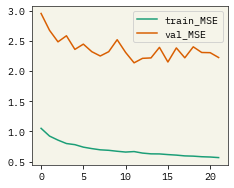

In [ ]:
#tests
plt.plot(result['mean_absolute_error'], label="train_MSE")
plt.plot(result['val_mean_squared_error'], label="val_MSE")
plt.legend()
plt.show()

In [ ]:
# train_data is a shuffled tf object
# it'd be randomly sampled and it'd unsynchronize x and y in mse computing
X_train, y_train = [], []
for x, y in train_data.unbatch():
  X_train.append(x)
  y_train.append(y)

train = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)
    ).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

X_train, y_train = train, np.concatenate([y for x, y in train])
X_test, y_test = test_data, np.concatenate([y for x, y in test_data])
X_val, y_val = val_data, np.concatenate([y for x, y in val_data])

In [ ]:
def mse(y, pred):
  # return np.mean((y-pred)**2)
  return mean_squared_error(y, pred)

def mae(y, pred):
  return mean_absolute_error(y, pred)

def r2(y, pred):
  return r2_score(y, pred)

def corr(y, pred):
  return np.corrcoef(y, pred)[0,1]

def acc(y, pred, threshold):
  acc = sum((abs(pred - y)<threshold))/len(pred)
  return acc

def eval(model, y, X):
  pred = model.predict(X)[:,0]
  # yvar = model.predict(X)[:,1]

  plt.plot(y, y, color='gray')
  plt.plot(y, pred, marker="o", linestyle="", alpha=0.4)
  plt.xlim(min(y), max(y))
  plt.ylim(min(y), max(y))
  plt.xlabel("label LogS")
  plt.ylabel("predicted LogS")
  # plt.text(min(y) + 1, max(y) - 2, f"r-sq = {r2(y, pred):.3f}")
  plt.text(min(y) + 1, max(y) - 2, f"corr = {corr(y, pred):.3f}")
  plt.text(min(y) + 1, max(y) - 3, f"RMSE = {np.sqrt(mse(y, pred)):.3f}")
  plt.text(min(y) + 1, max(y) - 4, f"MAE = {mae(y, pred):.3f}")
  plt.text(min(y) + 1, max(y) - 5, f"acc-1 = {acc(y, pred, 1):.3f}")
  plt.tight_layout()
  plt.savefig(f"{model_path}/{model_name}_eval.png", dpi=300)

def eval_SD(model, y, X):
  pred = model.predict(X)[:,0]
  yvar = model.predict(X)[:,1]

  plt.plot(y, np.sqrt(yvar), marker="o", linestyle="", alpha=0.4)
  plt.plot(y, y)
  plt.xlim(min(y), max(y))
  plt.ylim(min(y), max(y))
  plt.xlabel("label SD")
  plt.ylabel("predicted sqrt(var)")
  plt.text(min(y) + 1, max(y) - 2, f"r-sq = {r2(y, pred):.3f}")
  plt.text(min(y) + 1, max(y) - 3, f"RMSE = {np.sqrt(mse(y, pred)):.3f}")
  plt.text(min(y) + 1, max(y) - 4, f"MAE = {mae(y, pred):.3f}")
  plt.savefig(f"{model_path}/{model_name}_eval_SD.png")


In [ ]:
# m.evaluate(train_data)
# m.evaluate(test_data)
# m.evaluate(val_data)

1192/1192 [==============================] - 21s 14ms/step


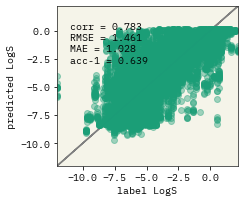

In [ ]:
# print(f"Train => MSE: {mse(y_train, m.predict(X_train)): 3.4f}")
# print(f"Test  => MSE: {mse(y_test, m.predict(X_test)): 3.4f}")
# print(f"Valid => MSE: {mse(y_val, m.predict(X_val)): 3.4f}\n")

eval(m, y_val, X_val)


In [ ]:
df_SolChal1_data = df_SolChal1.dropna(axis=0)
df_SolChal1_data = tf.data.Dataset.from_tensor_slices(
    (df_SolChal1_data["SELFIES_TOKENS"].to_list(), df_SolChal1_data["Solubility"].to_list())
    )

df_SolChal2_1_data = df_SolChal2_1.dropna(axis=0)
df_SolChal2_1_data = tf.data.Dataset.from_tensor_slices(
    (df_SolChal2_1_data["SELFIES_TOKENS"].to_list(), df_SolChal2_1_data["Solubility"].to_list())
    )

df_SolChal2_2_data = df_SolChal2_2.dropna(axis=0)
df_SolChal2_2_data = tf.data.Dataset.from_tensor_slices(
    (df_SolChal2_2_data["SELFIES_TOKENS"].to_list(), df_SolChal2_2_data["Solubility"].to_list())
    )

1/1 [==============================] - 0s 26ms/step


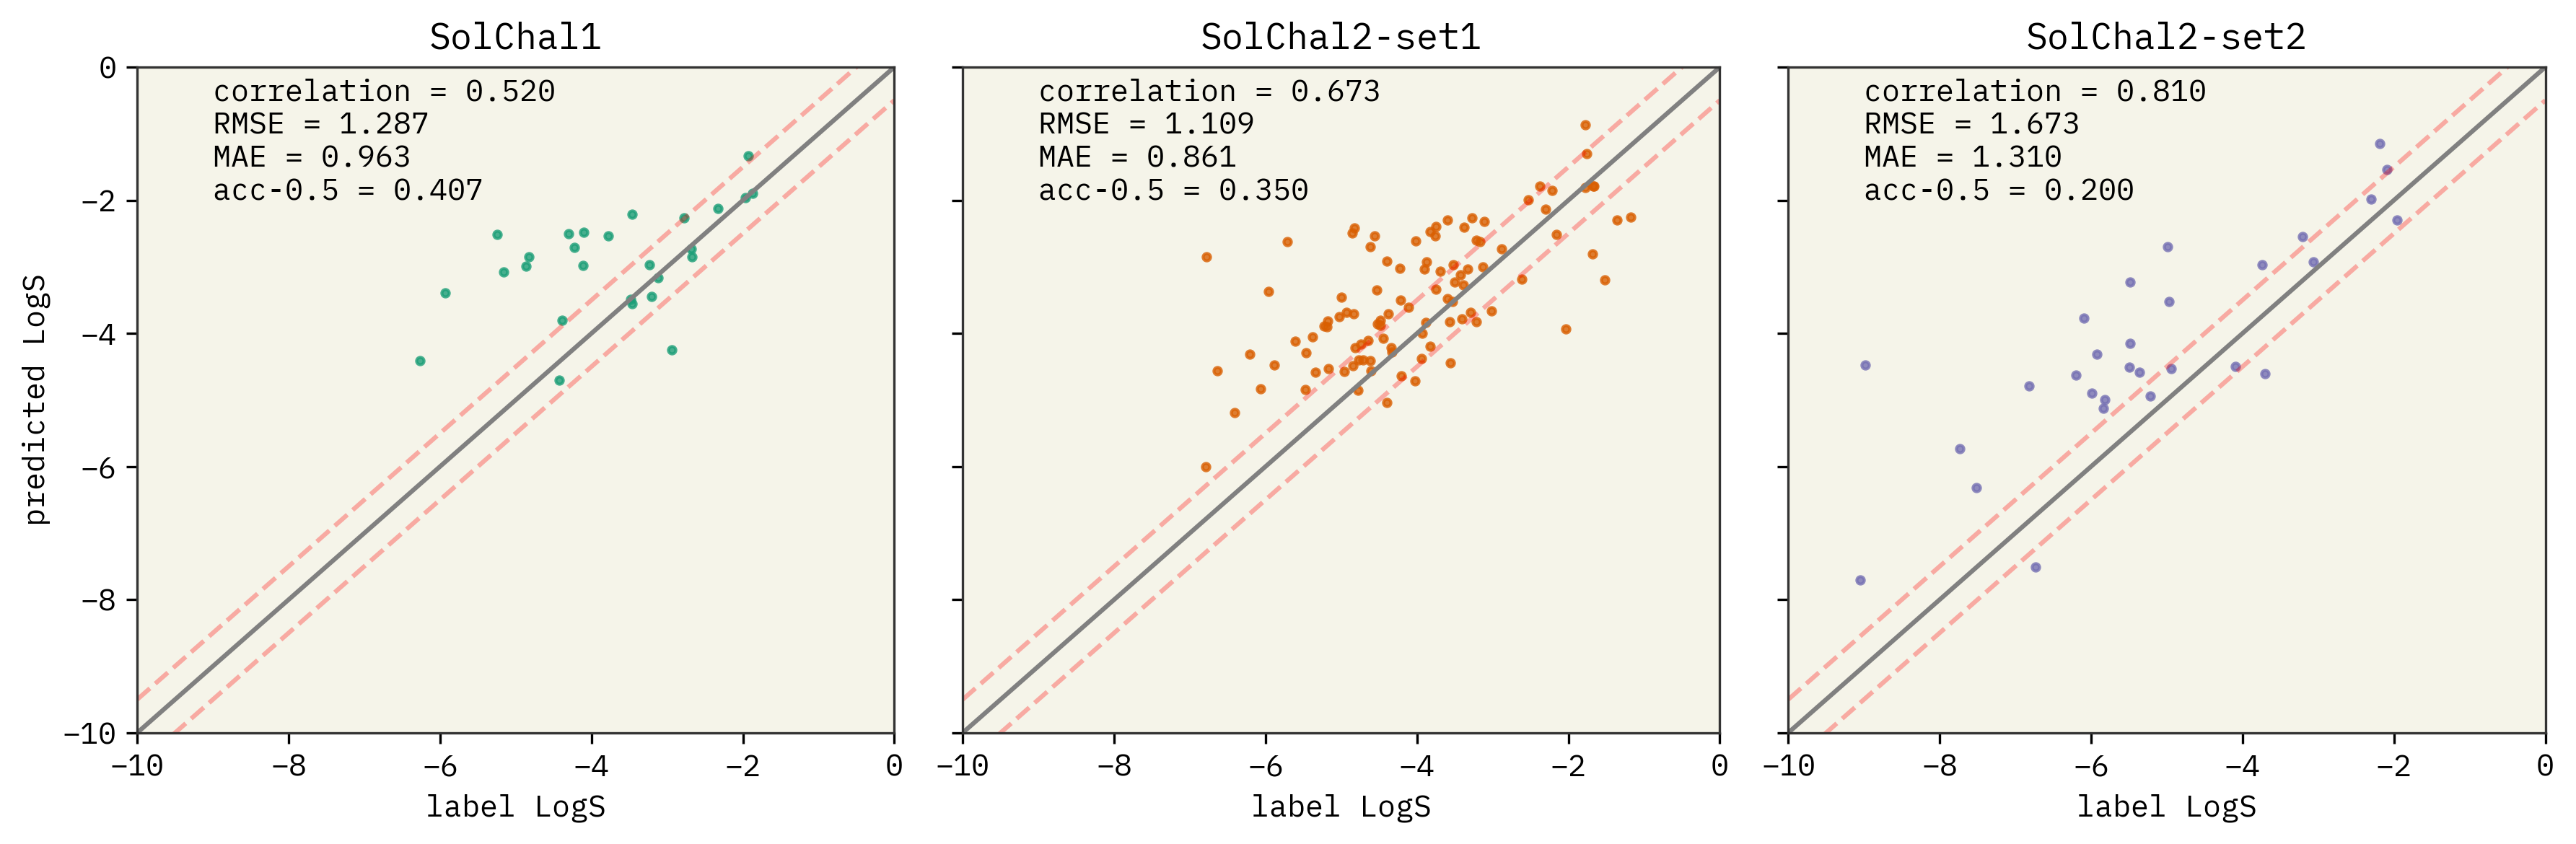

In [ ]:
dbs = {"SolChal1":df_SolChal1_data,
       "SolChal2-set1":df_SolChal2_1_data,
       "SolChal2-set2":df_SolChal2_2_data,
       }

th=0.5

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4), dpi=300)
for i, (name, db) in enumerate(dbs.items()):
  ax = axs[i]
  y = [y.numpy() for x, y in db]
  X = db.batch(888) #huge batch to take all data
  pred = m.predict(X)[...,0].reshape(-1)
    # ax = axs[i]
  ax.scatter(
      y, pred, s=6, alpha=0.8, color=f"C{i}"
  )

  lim = (-10.0,0.0)
  upper = (lim[0]+th, lim[1]+th)
  lower = (lim[0]-th, lim[1]-th)
  ax.plot(lim,lim, color='gray')
  ax.plot(lim, upper, color='red', alpha=0.3, ls='--')
  ax.plot(lim, lower, color='red', alpha=0.3, ls='--')
  ax.set_title(name)
  # ax.set_xlim([min(y), max(y)])
  # ax.set_ylim([min(y), max(y)])
  ax.set_xlim(lim)
  ax.set_ylim(lim)
  ax.set_xlabel("label LogS")
  if (i==0):
    ax.set_ylabel("predicted LogS")

  # plt.text(min(y) + 1, max(y) - 1, f"correlation = {np.corrcoef(y, pred)[0,1]:.3f}")
  # ax.text(lim[0] + 1, lim[1] - 0.5, f"r-sq = {r2(y, pred):.3f}")
  ax.text(lim[0] + 1, lim[1] - 0.5, f"correlation = {corr(y, pred):.3f}")
  ax.text(lim[0] + 1, lim[1] - 1.0, f"RMSE = {np.sqrt(mse(y, pred)):.3f}")
  ax.text(lim[0] + 1, lim[1] - 1.5, f"MAE = {mae(y, pred):.3f}")
  ax.text(lim[0] + 1, lim[1] - 2.0, f"acc-{th} = {acc(y, pred, th):.3f}")
plt.tight_layout()
plt.savefig(f"{model_path}/{model_name}_solChalDB.png")
plt.show()


                     name  Solubility
5   2-chloromandelic_acid         NaN
11              Ephedrine         NaN
19          Marbofloxacin         NaN
22        Pseudoephedrine         NaN
1/1 [==============================] - 4s 4s/step


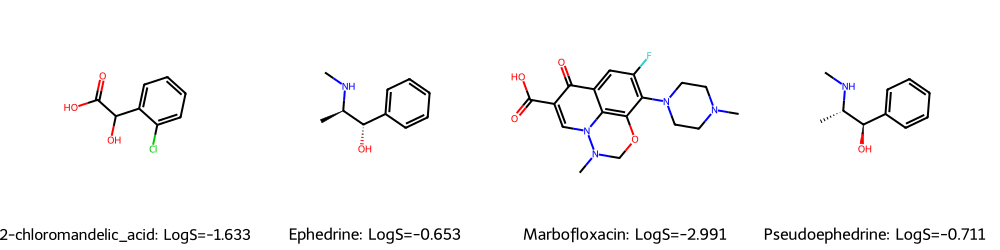

In [ ]:
from rdkit.Chem import Draw
# In SolChal1, some compounds were too soluble:
# 6  2-chloromandelic acid
# 12 1R-2S-ephedrine
# 20 marbofloxacin
# 23 1R-2R-pseudoephedrine
# Paper indexes start on 1 --> [5, 11, 19, 22]

too_soluble = df_SolChal1.iloc[[5, 11, 19, 22]]
print(too_soluble[["name", "Solubility"]])
X = too_soluble["SELFIES_TOKENS"]
S = list(m.predict(X.to_list()).reshape(-1))

legends = [f"{m}: LogS={s:>3.3f}" for m, s in zip(too_soluble["name"], S)]

mols = [Chem.MolFromSmiles(sml) for sml in too_soluble['SMILES']]
Draw.MolsToGridImage(
    mols, molsPerRow=4, subImgSize=(250, 250), legends=legends,
)

            name  Solubility
9     Diflunisal   -5.935889
16  Indomethacin   -2.940848
23    Probenecid   -4.864336
28   Terfenadine   -7.741178
1/1 [==============================] - 0s 45ms/step


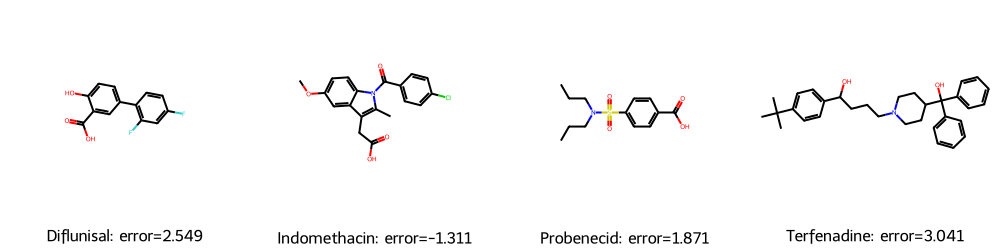

In [ ]:
from rdkit.Chem import Draw
# In SolChal1, some compounds were consistently bad predicted:
# 10 - Difunisal
# 17 - Indomethacin
# 24 - Probenecid
# 29 - Terfenadine
# Paper indexes start on 1 --> [9, 16, 23, 28]

least_predicted = df_SolChal1.iloc[[9, 16, 23, 28]]
print(least_predicted[["name", "Solubility"]])
X = least_predicted["SELFIES_TOKENS"]
S = list(m.predict(X.to_list()).reshape(-1))

legends = [f"{m}: error={(s-l):>3.3f}" for m, s, l in zip(least_predicted["name"], S, least_predicted["Solubility"])]

mols = [Chem.MolFromSmiles(sml) for sml in least_predicted['SMILES']]
Draw.MolsToGridImage(
    mols, molsPerRow=4, subImgSize=(250, 250), legends=legends,
)

In [ ]:
# from google.colab import files
# !tar -cvf {model_name}.tar {model_name}*
# files.download( f"{model_name}.tar" )